In [1]:
!date

Fri Feb 28 15:18:39 PST 2020


# Validate 10x and SS at with 3' amount

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/t2g.txt", sep="\t", header=None, names=cols)

In [4]:
def swap_start(start, stop, strand):
    new_start = start
    new_stop = stop
    if strand=="-":
        new_start = stop
        new_stop = start
    return new_start, new_stop

In [5]:
tmp = t2g.apply(lambda x: swap_start(x["start"], x["stop"], x["strand"]), axis=1).tolist()
t2g[["new_start", "new_stop"]] = pd.DataFrame(tmp, columns=["new_start", "new_stop"])

# Group isoforms by (1) Gene and then (2) Transcripton stop sites

In [6]:
gb = t2g.groupby(["chromosome", "gene_name", "new_stop"])["transcript_name"].apply(list)
gb = gb.reset_index()
gb = gb.rename(columns={"transcript_name":"tss_same"})
gb["tss_len"] = gb["tss_same"].apply(lambda x: len(x))

In [7]:
gb.tss_len.max()

23

In [8]:
gb["n_tss_same"] = gb["tss_same"].apply(lambda x: len(x))

num_iso_per_gene = t2g.groupby("gene_name")["transcript_name"].count()
max_tss_set_size = gb.groupby("gene_name")["tss_len"].apply(max)
num_tss_with_1_iso = gb.groupby("gene_name")["tss_len"].apply(lambda x: (np.array(x)==1).sum())

gb["n_iso"] = gb["gene_name"].map(num_iso_per_gene)
gb["max_tss_size"] = gb["gene_name"].map(max_tss_set_size)
gb["num_tss_1_iso"] = gb["gene_name"].map(num_tss_with_1_iso)

txn_list = gb["tss_same"].explode().values

#gb["tss_same"] = gb.tss_same.astype(str)
gb["tss_class"] = np.arange(gb.shape[0])

In [9]:
t2g = gb.sort_values("gene_name")

In [10]:
t2g

,chromosome,gene_name,new_stop,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class
76737,7,0610005C13Rik,45568174,[0610005C13Rik-203],1,1,11,1,11,76737
76733,7,0610005C13Rik,45567794,[0610005C13Rik-204],1,1,11,1,11,76733
76734,7,0610005C13Rik,45567935,[0610005C13Rik-205],1,1,11,1,11,76734
76735,7,0610005C13Rik,45568101,[0610005C13Rik-201],1,1,11,1,11,76735
76736,7,0610005C13Rik,45568124,[0610005C13Rik-209],1,1,11,1,11,76736
...,...,...,...,...,...,...,...,...,...,...
96844,MT,mt-Nd3,9806,[mt-Nd3-201],1,1,1,1,1,96844
96845,MT,mt-Nd4,11544,[mt-Nd4-201],1,1,1,1,1,96845
96846,MT,mt-Nd4l,10173,[mt-Nd4l-201],1,1,1,1,1,96846
96847,MT,mt-Nd5,13565,[mt-Nd5-201],1,1,1,1,1,96847


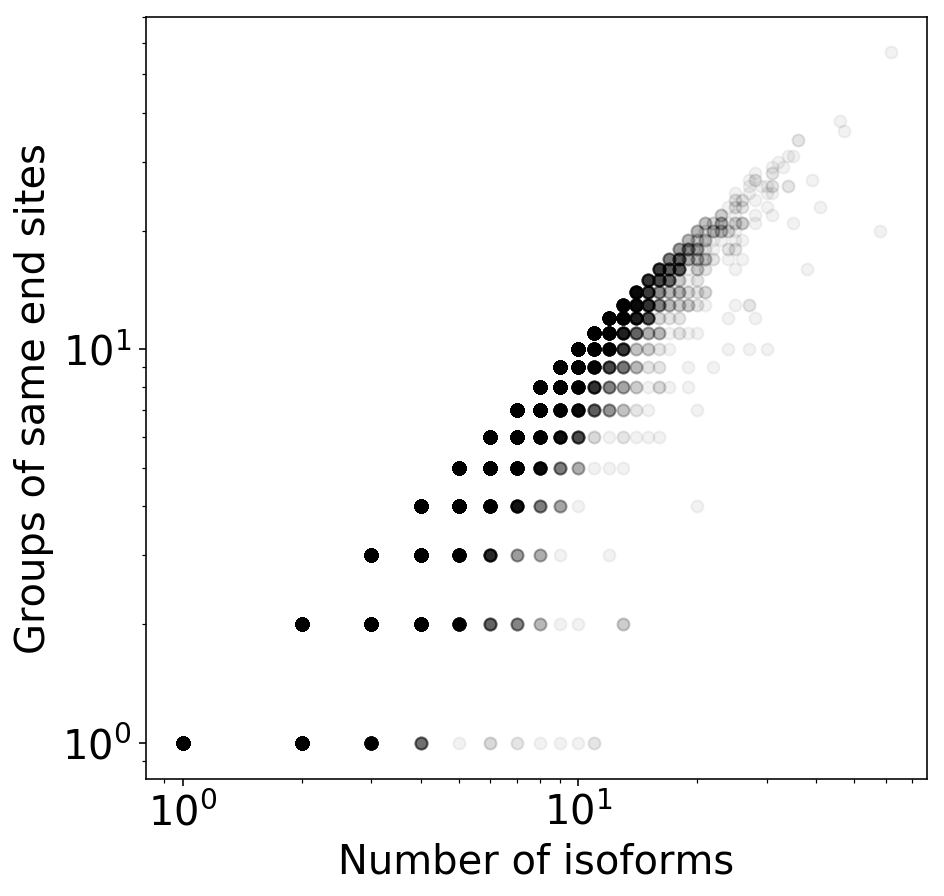

In [28]:
fig, ax = plt.subplots(figsize=(7,7))

x = t2g[~t2g["gene_name"].duplicated()]["n_iso"]
y = t2g.groupby("gene_name")["n_iso"].count()
alpha=0.05

ax.scatter(x,y, alpha=alpha, color="k")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Number of isoforms")
ax.set_ylabel("Groups of same end sites")

plt.show()

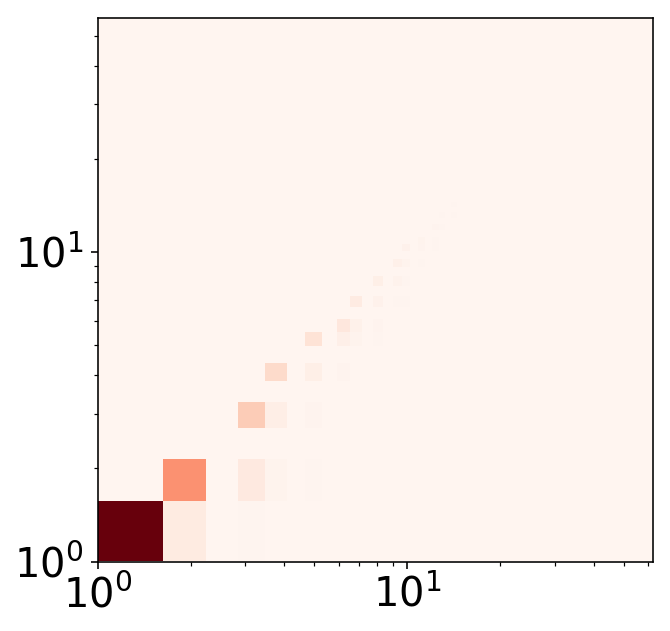

In [32]:
fig, ax = plt.subplots(figsize=(5,5))

x = t2g[~t2g["gene_name"].duplicated()]["n_iso"]
y = t2g.groupby("gene_name")["n_iso"].count()

heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

ax.imshow(heatmap.T, extent=extent, origin='lower', cmap="Reds")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [24]:
ss_t2g = pd.read_csv("cell_ranger_annotation/t2g_grouped.csv", index_col=0)
ss_t2g = t2g.sort_values("gene_name")

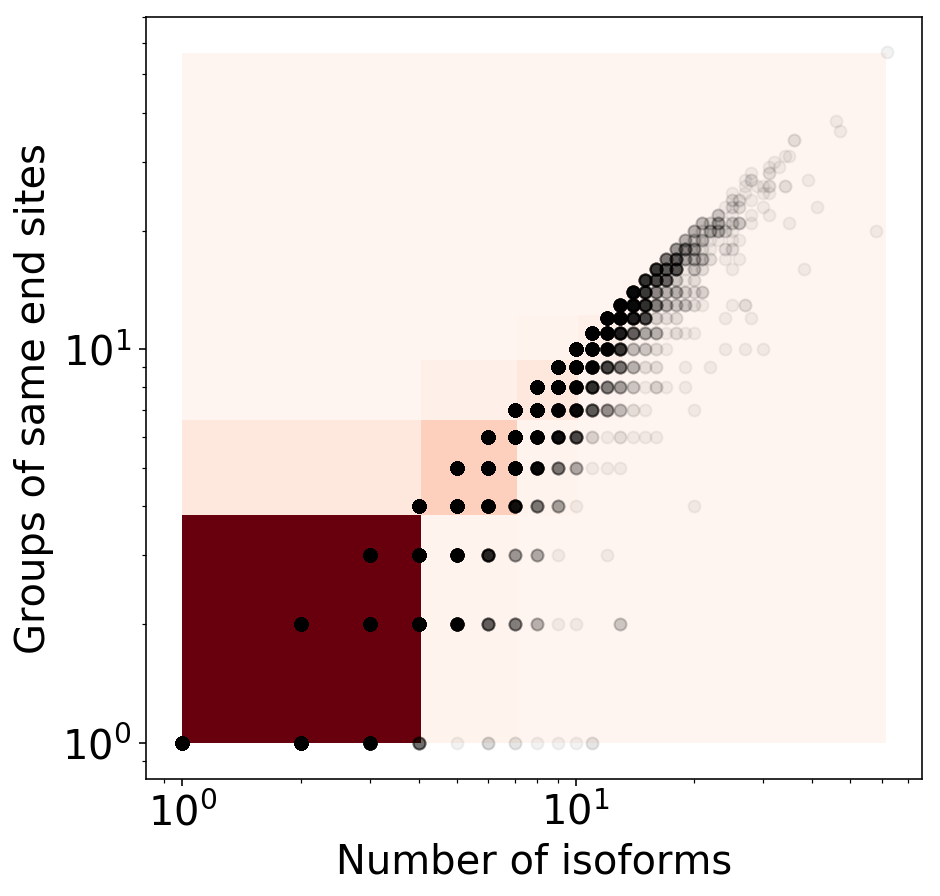

In [37]:
fig, ax = plt.subplots(figsize=(7,7))

x = ss_t2g[~ss_t2g["gene_name"].duplicated()]["n_iso"]
y = ss_t2g.groupby("gene_name")["n_iso"].count()
alpha=0.05

ax.scatter(x,y, alpha=alpha, color="k")

heatmap, xedges, yedges = np.histogram2d(x, y, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


ax.imshow(heatmap.T, extent=extent, origin='lower', cmap="Reds")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Number of isoforms")
ax.set_ylabel("Groups of same end sites")

plt.show()

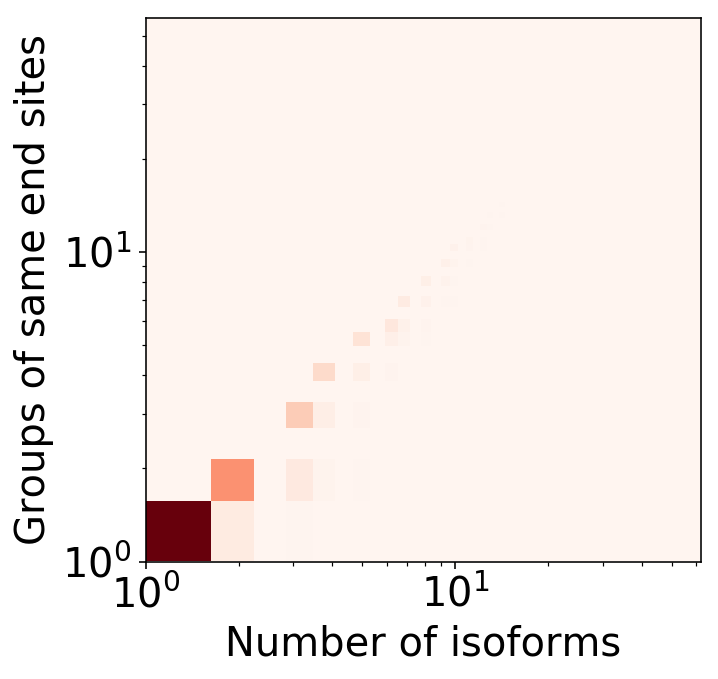

In [34]:
fig, ax = plt.subplots(figsize=(5,5))

x = ss_t2g[~ss_t2g["gene_name"].duplicated()]["n_iso"]
y = ss_t2g.groupby("gene_name")["n_iso"].count()

heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


ax.imshow(heatmap.T, extent=extent, origin='lower', cmap="Reds")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of isoforms")
ax.set_ylabel("Groups of same end sites")
plt.show()